# 0D Reactor: Postprocessing the FNN for the Decoder

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time
import shutil


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')

### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


# from scipy.integrate import solve_ivp
# import pyDOE
# from PCAfold         import PCA          as PCAA


import romnet                            as rmnt

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Data

In [2]:
OutputDir    = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_500Cases_CH4_/')


NVarsRed     = 10

valid_perc   = 20.

FixedMinVal  = 1.e-14

n_ics        = 500


ColorVec     = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
# try:
#     os.makedirs(TestDir)
# except OSError as e:
#     pass



path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/0DReact_Isobaric_500Cases_CH4_Autoencoder/Autoencoder/LIN_10/')
FigDir          = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')

LineVec         = ['-',':','--','.-']*10
ColorVec        = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

In [3]:
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'Autoencoded/')
except:
    pass
shutil.copyfile(OutputDir+'/Orig/CleanVars_ToRed.csv',    OutputDir+'/' + str(NVarsRed) + 'Autoencoded/CleanVars_ToRed.csv')
shutil.copyfile(OutputDir+'/Orig/CleanVars_NotToRed.csv', OutputDir+'/' + str(NVarsRed) + 'Autoencoded/CleanVars_NotToRed.csv')

'/Users/sventur/WORKSPACE/ROMNet/romnet/scripts/generating_data/0DReactor/../../../../../ROMNet/Data/0DReact_Isobaric_500Cases_CH4_//10Autoencoded/CleanVars_NotToRed.csv'

## Loading ROMNet's Input Data File

In [4]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/generating_data/0DReactor/../../../../../ROMNet/0DReact_Isobaric_500Cases_CH4_Autoencoder/Autoencoder/LIN_10/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [5]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.architecture, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - autoencoder.py            ]:   Constructing Autoencoder: 
[ROMNet - system_of_components.py   ]:     Constructing System of Components: Encoder
[ROMNet - component.py              ]:       Constructing Component: FNN
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x166652670>, <keras.layers.core.dense.Dense object at 0x1666033a0>])
[ROMNet - system_of_components.py   ]:     Constructing System of Components: Decoder
[ROMNet - component.py              ]:       Constructing Component: FNN
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<keras.layers.core.dense.Dense object at 0x166a22b80>, <keras.layers.core.dropout.Dropout object at 0x166603c70>, <keras.layers.core.dense.D

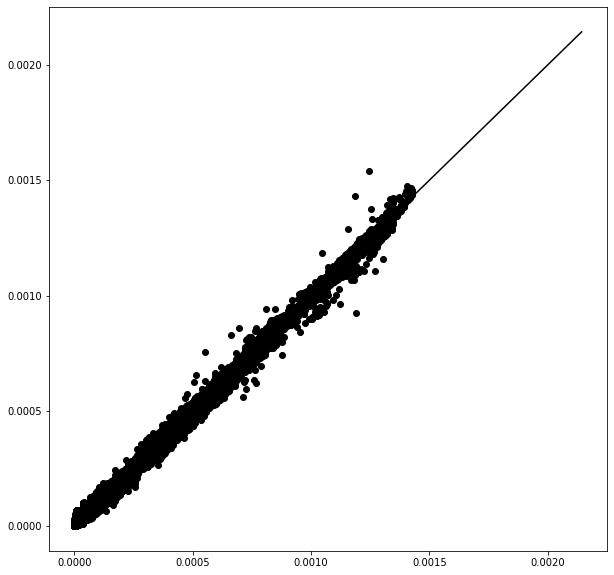

In [6]:
input_vars   = InputData.input_vars_all
output_vars  = InputData.output_vars

FileName     = InputData.path_to_data_fld+'/valid/pts/Input.csv'
input_data   = pd.read_csv(FileName)[input_vars]

FileName     = InputData.path_to_data_fld+'/valid/pts/Output.csv'
output_data  = pd.read_csv(FileName)[output_vars]

yMat         = model.predict(input_data)  

SoI          = 'H'
iS           = list(output_vars).index(SoI)

plt.figure(figsize=(10,10))
plt.plot(output_data[SoI], yMat[:,iS], 'ko')
plt.plot([0, output_data[SoI].max()*1.5],[0, output_data[SoI].max()*1.5], 'k-')

## Evaluating Branch on Test Data

In [7]:
input_vars      = pd.read_csv(InputData.path_to_data_fld+'/../Orig/CleanVars_ToRed.csv', header=None).to_numpy()[0,:]
input_vars_not  = pd.read_csv(InputData.path_to_data_fld+'/../Orig/CleanVars_NotToRed.csv', header=None).to_numpy()[0,:]

input_vars0     = []
for var in input_vars:
    input_vars0.append(var+'0')
input_vars_not0 = []
for var in input_vars_not:
    input_vars_not0.append(var+'0')


output_vars_not0= input_vars_not0
output_vars     = ['x_'+str(ix+1) for ix in range(InputData.NRODs)]
output_vars0    = ['x0_'+str(ix+1) for ix in range(InputData.NRODs)]

In [8]:
output_vars_tot0 = np.append(input_vars_not0, output_vars0)
Header           = output_vars_tot0[0]
for var in output_vars_tot0[1:]:
    Header      += ','+var
FileName = OutputDir+'/'+str(InputData.NRODs)+'Autoencoded/Vars0.csv'
with open(FileName, 'w') as the_file:
    the_file.write(Header+'\n')

output_vars_tot  = np.append(input_vars_not,  output_vars)
Header           = output_vars_tot[0]
for var in output_vars_tot[1:]:
    Header      += ','+var
FileName = OutputDir+'/'+str(InputData.NRODs)+'Autoencoded/Vars.csv'
with open(FileName, 'w') as the_file:
    the_file.write(Header+'\n')

In [9]:
FileName = os.path.join(OutputDir, 'Orig/train/ext/CleanVars.csv')
Vars     = pd.read_csv(FileName, header=None)
Vars     = list(Vars.to_numpy()[0,:])
Vars0    = [Vars[i]+'0' for i in range(len(Vars))]
for iC in range(n_ics):
    FileName         = OutputDir+'/Orig/train/ext/y.csv.'+str(iC+1)
    DataNew          = pd.read_csv(FileName, header=0)
    Nts              = len(DataNew)
    DataTemp         = DataNew.iloc[[0]][Vars] #DataTemp.iloc[1][Vars]
    DataTemp         = DataTemp.loc[DataTemp.index.repeat(Nts)]
    DataTemp.reset_index(drop=True, inplace=True)
    DataNew[Vars0]   = DataTemp
    DataTemp['t']    = DataNew['t']
    DataNew['t']     = np.maximum(DataNew['t'].to_numpy() - DataTemp['t'].iloc[[0]].to_numpy(), FixedMinVal)
    if (iC==0):
        Data         = DataNew
    else:
        Data         = pd.concat([Data, DataNew], axis=0)
Data.reset_index(drop=True, inplace=True)

In [10]:
input_data_Not       = Data[np.append(['t'],input_vars_not0)]
input_data           = pd.DataFrame(model.net.system_of_components['Encoder'].components['FNN'].call(Data[input_vars0], model.net.layers_dict, None, training=False), columns=output_vars0)
input_data           = pd.concat([input_data_Not,input_data], axis=1)

output_data_Not      = Data[np.append(['t'],input_vars_not)]
output_data          = pd.DataFrame(model.net.system_of_components['Encoder'].components['FNN'].call(Data[input_vars], model.net.layers_dict, None, training=False), columns=output_vars)
output_data          = pd.concat([output_data_Not,output_data], axis=1)

## Splitting Data and Writing Database 

In [11]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(InputData.NRODs)+'Autoencoded/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(InputData.NRODs)+'Autoencoded/valid/')
except:
    pass

In [12]:
data_id    = 'pts'

DataNoZero           = Data[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/'+str(InputData.NRODs)+'Autoencoded/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(InputData.NRODs)+'Autoencoded/valid/'+data_id+'/')
except:
    pass

DataInput  = input_data
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(InputData.NRODs)+'Autoencoded/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(InputData.NRODs)+'Autoencoded/valid/'+data_id+'/Input.csv', index=False)

DataOutput = output_data
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(InputData.NRODs)+'Autoencoded/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(InputData.NRODs)+'Autoencoded/valid/'+data_id+'/Output.csv', index=False)